This is the script how to use Joint/Stage-wise discretization  

Note: Joint discretization is super fast than stage-wise.

Assume $j$ is the best cut point set in $j$th iteration, we could find another cut point ${t_{j+1}}$ to reach maximum MI or minimum P_value.  
We define sample size $n$, number of predictors $p$ and $k$ selected variables.
Time complexity of joint discretization:
* $\argmax(I(X_{j+1};Y) - I(X_{j};Y)) \rightarrow O(npk)$
* $\argmin(P(I(X_{j+1};Y) - I(X_{j};Y))) \rightarrow O(npk)$

Furthermore, we could further decrese the time complexity to $O(npl)$, where $l$ is the unique selected variable of $k$.

In [17]:
import sys,os
import pandas as pd
import numpy as np
sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append('../Discretization/')


from joint_nalgorithmMI import efficientJointDiscretizationMI
from joint_nalgorithmPvalue import efficientJointDiscretizationPvalue
from joint_lognalgorithmPvalue import stageWiseDiscretizationPvalue
from joint_lognalgorithmMI import stageWiseDiscretizationMI

# from data_generator_v2 import dataGenerator

# num_total_features = 30
# num_relevant_features = 20
# num_samples = 100
# df_X, y, variable_lst, btrue, formula = dataGenerator(n=num_samples,
#                                                     rho = 0.8,
#                                                     p = num_total_features,
#                                                     r = num_relevant_features,
#                                                     num_terms = 10,
#                                                     degree = 5,
#                                                     alpha = None,
#                                                     beta = 0.5,
#                                                     SNR = 10,
#                                                     random_state = 0,
#                                                     model = 'binomial').sample()



/Users/panos/git/PhD/Discretization/data_generator_v2.py:161: RuntimeWarning: overflow encountered in exp
  mu = 1/(1+ np.exp(-eta))
/Users/panos/git/PhD/Discretization/data_generator_v2.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  snr = np.sqrt(np.var(mu)/np.mean(v))
/Users/panos/opt/anaconda3/envs/node2vec2rank/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/panos/git/PhD/Discretization/data_generator_v2.py:161: RuntimeWarning: overflow encountered in exp
  mu = 1/(1+ np.exp(-eta))
/Users/panos/git/PhD/Discretization/data_generator_v2.py:161: RuntimeWarning: overflow encountered in exp
  mu = 1/(1+ np.exp(-eta))


In [21]:
# # With maximum MI
# dims_list, step_fmi, best_bins, values, best_counts, best_y_counts, best_cond_entr, num_bins =\
#       efficientJointDiscretizationMI(duplicate=True, early_stopping='chi_square_adjust',  delta=0.05).fit(df_X.values, y)

In [22]:
# print(f'Dimension cuts: {dims_list}')

# features_selected = np.unique(dims_list)
# num_features_selected = features_selected.shape[0]
# percentage = num_features_selected/num_relevant_features
# false_positives = (features_selected > num_relevant_features).sum()/num_features_selected

# print(f'{percentage*100}% features selected: {features_selected}')
# print(f'{false_positives}% false positives')



Dimension cuts: [3]
5.0% features selected: [3]
0.0% false positives


In [7]:
# def discretize(data, bins):
#     split = np.array_split(np.sort(data), bins)
#     cutoffs = [x[-1] for x in split]
#     cutoffs = cutoffs[:-1]
#     discrete = np.digitize(data, cutoffs, right=True)
#     return discrete, cutoffs

In [27]:
# ## real data gold cluster

# data_fn = '/Users/panos/Desktop/yiwen/gold.csv'

# data_df = pd.read_csv(data_fn, header=0, index_col=False)
# print(data_df.columns.to_list())
# target = data_df.hl_gap.to_numpy()

# num_bins = 4
# target_disc = pd.qcut(data_df.hl_gap, num_bins,labels= np.arange(num_bins), retbins=False).to_numpy() 

# X = data_df.drop(['structure','number_atoms', 'hl_gap'], axis=1)

# y = target_disc.copy()

# features = X.columns.to_numpy()

# dims_list, step_fmi, best_bins, values, best_counts, best_y_counts, best_cond_entr, num_bins =\
#       efficientJointDiscretizationMI(duplicate=True, early_stopping='chi_square_adjust', delta=0.05).fit(X.values, y)

# print(f'Dimension cuts: {dims_list}')

# features_selected = np.unique(dims_list)

# features[features_selected-1]

['structure', 'number_atoms', 'delta_e', 'temperature', 'rel_coord_0', 'rel_coord_1', 'rel_coord_2', 'rel_coord_3', 'rel_coord_4', 'rel_coord_5', 'rel_coord_6', 'rel_coord_7', 'radius_gyration', 'hl_gap', 'chem_hardness', 'elec_chem_potential', 'neg_homo', 'neg_lumo', 'evdw_per_atom', 'delta_evdw', 'delta_hardness', 'delta_elec_chem_potential', 'force_per_atom']
Dimension cuts: [11, 15, 11, 11, 17, 14, 17, 2, 13, 12, 13, 14]


array(['temperature', 'radius_gyration', 'chem_hardness',
       'elec_chem_potential', 'neg_homo', 'neg_lumo', 'delta_evdw'],
      dtype=object)

In [23]:
# ## real data GSE102484

# from sklearn.preprocessing import LabelEncoder


# data_fn = '/Users/panos/Desktop/yiwen/GSE102484_gene_profile.csv'

# data_df = pd.read_csv(data_fn, header=0, index_col=False)
# data_df.drop('Output1', axis=1, inplace=True)
# print(data_df.columns.to_list())
# target = data_df.Output2.to_numpy()
# data_df.drop('Output2', axis=1, inplace=True)
# X = data_df.copy()

# # num_bins = 4
# # target_disc = pd.qcut(data_df.hl_gap, num_bins,labels= np.arange(num_bins), retbins=False).to_numpy() 

# # X = data_df.drop(['structure','number_atoms', 'hl_gap'], axis=1)

# le = LabelEncoder()
# y = target.copy()
# y_le = le.fit_transform(y)
# le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(le_name_mapping)
# y = y_le
# y[y!=3]=0
# y[y!=0]=1


# features = X.columns.to_numpy()

# dims_list, step_fmi, best_bins, values, best_counts, best_y_counts, best_cond_entr, num_bins =\
#       efficientJointDiscretizationMI(duplicate=True, early_stopping='chi_square_adjust', =True, delta=0.05).fit(X.values, y)

# print(f'Dimension cuts: {dims_list}')

# features_selected = np.unique(dims_list)

# features[features_selected-1]

['PSME1', 'CISD1', 'SPDEF', 'ATF1', 'RHEB', 'IGF1R', 'FOXO3', 'GSTM2', 'RHOA', 'IL1B', 'ASAH1', 'RALA', 'ARHGEF12', 'SOX2', 'SERPINE1', 'HLA.DMA', 'EGF', 'SPTLC2', 'APP', 'TSKU', 'TMEM2', 'NOS3', 'CSNK1A1', 'NFATC4', 'TBP', 'SLC2A6', 'EZH2', 'ICAM3', 'BRCA1', 'PSMD4', 'PHKG2', 'ETV1', 'KDM5B', 'COG4', 'MCM3', 'TERT', 'SNX13', 'PAK4', 'DPH2', 'SNX6', 'EED', 'WIPF2', 'NENF', 'RPN1', 'C2CD2L', 'GABPB1', 'POLR2K', 'PTK2B', 'PAF1', 'POLR1C', 'RUVBL1', 'AKT1', 'SENP6', 'HSPB1', 'EBP', 'CASK', 'RRP8', 'PIK3C3', 'BHLHE40', 'BDH1', 'SH3BP5', 'PPP2R5A', 'EML3', 'BIRC5', 'EPRS', 'PAX8', 'CBLB', 'PDS5A', 'DFFB', 'TGFB3', 'XBP1', 'NMT1', 'ARFIP2', 'STAMBP', 'PRKX', 'FAH', 'PLP2', 'SOX4', 'TESK1', 'HN1L', 'RRAGA', 'ELOVL6', 'ACBD3', 'PMAIP1', 'TWF2', 'HDAC6', 'CCND1', 'PXN', 'PHKB', 'NFKBIB', 'CASC3', 'MLEC', 'GLI2', 'USP22', 'TMED10', 'CHERP', 'PIK3CA', 'TRAPPC6A', 'ATP2C1', 'USP14', 'APPBP2', 'RPS6', 'ECH1', 'HDAC2', 'DFFA', 'MRPL19', 'SUZ12', 'CSNK2A2', 'TICAM1', 'KIAA0100', 'PAICS', 'CDK2', 'EDN

array(['EDN1'], dtype=object)

(array([300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 383.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

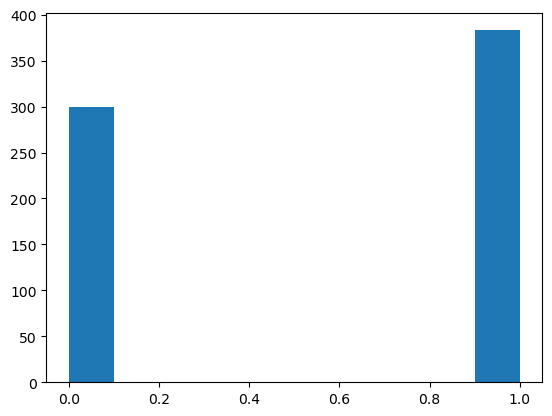

In [36]:
# import matplotlib.pyplot as plt

# plt.hist(y)

In [39]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


## load and prepare the data

data_fn = '/Users/panos/Desktop/yiwen/GSE102484_gene_profile.csv'
data_df = pd.read_csv(data_fn, header=0, index_col=False)
data_df.drop('Output1', axis=1, inplace=True)
target = data_df.Output2.to_numpy()
data_df.drop('Output2', axis=1, inplace=True)
features = data_df.columns.to_numpy()
X = data_df.values.copy()

le = LabelEncoder()
y = target.copy()
y_le = le.fit_transform(y)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
y = y_le


#making stage 0 one versus all
y[y>0]=1
# y[y!=0]=1


#start the k stratified fold training and feat sel
skf = StratifiedKFold(n_splits=10)
knn_accuracies = []
knn_accuracies_mi = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")

    #get the splits
    fold_train_X_data = X[train_index,:]
    fold_train_Y_data = y[train_index]
    fold_test_X_data = X[test_index,:]
    fold_test_Y_data = y[test_index]

    #run feature selection
    dims_list, step_fmi, best_bins, values, best_counts, best_y_counts, best_cond_entr, num_bins =\
      efficientJointDiscretizationMI(duplicate=True, early_stopping='chi_square_adjust',  delta=0.05).fit(fold_train_X_data, fold_train_Y_data)
    features_selected = np.unique(dims_list)
    print(f'Features selected in fold {i} {features[features_selected-1]}')

    #run KNN with selected features
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(fold_train_X_data[:,features_selected], fold_train_Y_data)
    predicted = knn.predict(fold_test_X_data[:,features_selected])
    acc = accuracy_score(fold_test_Y_data, predicted)
    knn_accuracies_mi.append(acc)
    print(f'knn accuracy with selected features in fold {i} {acc}')


    #run KNN with all features
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(fold_train_X_data, fold_train_Y_data)
    predicted = knn.predict(fold_test_X_data)
    acc = accuracy_score(fold_test_Y_data, predicted)
    knn_accuracies.append(acc)
    print(f'knn accuracy with all features in fold {i} {acc}')





Fold 0:
Features selected in fold 0 ['GATA2']
Fold 1:
size 342 101 0.0354512174650945 True 5.112474437627812e-07


IndexError: arrays used as indices must be of integer (or boolean) type

In [183]:
# import matlab.engine 

# eng = matlab.engine.start_matlab()
# eng.addpath('/Users/panos/Desktop/yiwen/')



'/Users/panos/Documents/MATLAB:/Applications/MATLAB_R2022b.app/toolbox/matlab/addon_enable_disable_management/matlab:/Applications/MATLAB_R2022b.app/toolbox/matlab/addon_updates/matlab:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons/cef:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons/fileexchange:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons/supportpackages:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons_common/matlab:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons_install_location/matlab:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons_product:/Applications/MATLAB_R2022b.app/toolbox/matlab/addons_registry/matlab:/Applications/MATLAB_R2022b.app/toolbox/matlab/addressbar_plugins/browse_for_folder_button/matlab:/Applications/MATLAB_R2022b.app/toolbox/matlab/addressbar_plugins/cd_up_one_dir_button/matlab:/Applications/MATLAB_R2022b.app/toolbox/matlab/appcontainer:/Applications/MATLAB_R2022b.app/tool

In [184]:
# X = data_df.radius_gyration.to_numpy()

# X_matlab = matlab.double(list(X))
# Y_matlab = matlab.double(list(np.float64(y)))

# eng.ross_estimator(Y_matlab,X_matlab)


0.0675123851039805

In [133]:
# # with p_values
# dims_list, step_fmi, best_bins, values, best_counts, best_y_counts, best_cond_entr, num_bins =\
#       efficientJointDiscretizationPvalue(duplicate=True, early_stopping='chi_square_adjust', delta_correction=True, delta=0.05).fit(df_X.values, y)

In [134]:
# dims_list, step_fmi, num_bins, values

In [135]:
# from copy import deepcopy
# dfs = deepcopy(df_X)
# dfs['Y'] = y
# best_subsetData_list, step_mi_list, dim_list, cutpoint_list, num_bins= \
#     stageWiseDiscretizationPvalue(delta=0.05, early_stopping='chi_square_adjust').fit(dfs)

In [136]:
# dim_list, step_mi_list, num_bins, cutpoint_list

In [137]:
# from copy import deepcopy
# dfs = deepcopy(df_X)
# dfs['Y'] = y

# best_subsetData_list, step_mi_list, dim_list, cutpoint_list, num_bins= \
#     stageWiseDiscretizationMI(delta=0.05, early_stopping='chi_square_adjust').fit(dfs)

In [138]:
# import numpy as np
# np.unique(dims_list)

In [139]:
# dim_list, step_mi_list, num_bins, cutpoint_list